# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Homecage-odor-exposure" data-toc-modified-id="Homecage-odor-exposure-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homecage odor exposure</a></div><div class="lev2 toc-item"><a href="#Import-data" data-toc-modified-id="Import-data-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import data</a></div><div class="lev3 toc-item"><a href="#Parameters" data-toc-modified-id="Parameters-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Parameters</a></div><div class="lev3 toc-item"><a href="#Import-behavior" data-toc-modified-id="Import-behavior-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Import behavior</a></div><div class="lev3 toc-item"><a href="#Import-calcium-imaging-data" data-toc-modified-id="Import-calcium-imaging-data-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Import calcium imaging data</a></div><div class="lev2 toc-item"><a href="#Clean-up-imaging-data" data-toc-modified-id="Clean-up-imaging-data-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Clean up imaging data</a></div><div class="lev2 toc-item"><a href="#Register-neurons" data-toc-modified-id="Register-neurons-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Register neurons</a></div><div class="lev2 toc-item"><a href="#Save-data" data-toc-modified-id="Save-data-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Save data</a></div><div class="lev1 toc-item"><a href="#Elevated-plus-maze" data-toc-modified-id="Elevated-plus-maze-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Elevated-plus maze</a></div><div class="lev2 toc-item"><a href="#Import-data" data-toc-modified-id="Import-data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import data</a></div><div class="lev3 toc-item"><a href="#Import-behavioral-data" data-toc-modified-id="Import-behavioral-data-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Import behavioral data</a></div><div class="lev3 toc-item"><a href="#Downsample-data" data-toc-modified-id="Downsample-data-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Downsample data</a></div><div class="lev3 toc-item"><a href="#Import-calcium-imaging-data" data-toc-modified-id="Import-calcium-imaging-data-213"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Import calcium imaging data</a></div><div class="lev3 toc-item"><a href="#Downsample-data-(if-necessary)" data-toc-modified-id="Downsample-data-(if-necessary)-214"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Downsample data (if necessary)</a></div><div class="lev3 toc-item"><a href="#Clean-data" data-toc-modified-id="Clean-data-215"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Clean data</a></div><div class="lev3 toc-item"><a href="#Save-data" data-toc-modified-id="Save-data-216"><span class="toc-item-num">2.1.6&nbsp;&nbsp;</span>Save data</a></div><div class="lev1 toc-item"><a href="#Headfixed-exposure" data-toc-modified-id="Headfixed-exposure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Headfixed exposure</a></div><div class="lev2 toc-item"><a href="#Create-behavioral-data" data-toc-modified-id="Create-behavioral-data-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create behavioral data</a></div><div class="lev2 toc-item"><a href="#Import-neural-data" data-toc-modified-id="Import-neural-data-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Import neural data</a></div><div class="lev3 toc-item"><a href="#Save-data" data-toc-modified-id="Save-data-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Save data</a></div>

In [1]:
% matplotlib inline
# %matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py as h5
import os
import time
import glob
import multiprocessing as mp
import custom
import pdb

/home/rung/anaconda3/envs/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
<a id='homecage'></a>
# Homecage odor exposure

## Import data

### Parameters

In [2]:
# Parameters
frame_max = 4500
frame_dur = 200
n_cores = 7
ts = np.arange(0, 300000, frame_dur)

# Input files
del_tmt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/del_free-tmt.csv'
del_pnt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/del_free-pnt.csv'
match_file = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/matches.csv'

behav_files = glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_TMT/PNOC_Behavior/*.xlsx') + \
              glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_PNT/PNOC_Behavior/*.xlsx')
ca_files = glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_TMT/PNOC_Traces/*.txt') + \
           glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_TMT/PNOC_Spikes/*.txt') + \
           glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_PNT/PNOC_Traces/*.txt') + \
           glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_PNT/PNOC_Spikes/*.txt')

# Output files
h5_out = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/homecage.h5'

### Import behavior

In [3]:
# Define import function
def import_behav(filename):
    _, subj, odor, order, epoch = os.path.splitext(os.path.basename(filename))[0].split('_')
    data = custom.etho_extract(filename)
    data.index = data.index * 1000
    
    return (subj, odor, order, epoch), data

In [4]:
# Import data
# This will lock up often. Not sure why...
# Lowered number of processes in pool and seems to work better... nope
# Keep Excel files closed seems to do the trick... nah
# Define pool AFTER defining all functions is the fix:
#     https://stackoverflow.com/questions/2782961/yet-another-confusion-with-multiprocessing-error-module-object-has-no-attribu
#     https://stackoverflow.com/questions/18947876/using-python-multiprocessing-pool-in-the-terminal-and-in-code-modules-for-django

p = mp.Pool(processes=n_cores)
exps, behav_import = zip(*p.map(import_behav, behav_files))

TypeError: 'generator' object has no attribute '__getitem__'

In [5]:
# Create dataframe from all animals
# Sessions are defined as set of epochs with the same odor. For example, 
# for one animal, the three experiments the animal underwent in a single 
# day: baseline, water, odor

sessions = set([x[:2] for x in exps])
dfs = []

# Combine epochs (base, h2o, odor) of the same experiment
epoch_dict = {'1': 'base', '2': 'h2o', '3':'odor'}

# Iterate over sessions
for session in sessions:
    subj, odor = session
    
    # Identify epochs of session
    epochs = {
        sess: behav_import[n] for n, sess in enumerate(exps)
        if subj in sess and odor in sess
    }

    # Downsample data and create dataframe for subject (with each epoch)
    subj_df = pd.DataFrame()
    for epoch_key, epoch_data in epochs.iteritems():
        old_ts = epoch_data.index
        data = epoch_data.as_matrix()
        data_ds = custom.resample(data, old_ts, ts, method=np.nanmean)
        epoch_df = pd.DataFrame(data_ds, columns=epoch_data.columns, index=ts)
        epoch_df.index = pd.MultiIndex.from_tuples(
            [(epoch_dict[epoch_key[-1]], x) for x in epoch_df.index],
            names=['epoch', 'timestamp']
        )
        subj_df = pd.concat([subj_df, epoch_df], axis=0)

    subj_df.columns = pd.MultiIndex.from_tuples(
        [epoch_key[:-1] + (x, ) for x in subj_df.columns],
        names=['subject', 'experiment', 'order', 'feature']
    )
    dfs.append(subj_df)

behav_df = pd.concat(dfs, axis=1, names=['subject', 'feature'])
behav_df = behav_df.sort_index(axis=1, level=0)
# behav_df = behav_df.interpolate()

/data/Dropbox (Stuber Lab)/analysis/random/custom/custom.py:37: RuntimeWarning: Mean of empty slice
  data_ds[..., bin_ds] = method(data[..., bin_pts], axis=-1)


### Import calcium imaging data
Each session is 1499 or 1500 frames

In [7]:
# Import data
ca_import = {
    tuple(os.path.splitext(os.path.basename(f))[0].split('_')): np.loadtxt(f, delimiter=',')
    for f in ca_files
}

In [8]:
# Create dataframe
dfs = []

for exp, exp_data in ca_import.iteritems():
    n_frames = min(exp_data.shape[1], frame_max)
    exp_index = pd.MultiIndex.from_product([['base', 'h2o', 'odor'], ts], names=['epoch', 'time'])[:n_frames]
    df = pd.DataFrame(exp_data.T[:n_frames], index=exp_index)
    df.columns = pd.MultiIndex.from_tuples(
        [exp + (x, ) for x in df.columns],
        names=['datatype', 'subject', 'experiment', 'order', 'neuron']
    )
    dfs.append(df)

neural_df = pd.concat(dfs, axis=1)
neural_df = neural_df.sort_index(axis=1, level=0)

In [9]:
neural_df

datatype      Spikes                                                    \
subject         H123                                                     
experiment       TMT                                                     
order              A                                                     
neuron            0       1       2        3        4       5       6    
epoch time                                                               
base  0       37.847  277.90  363.61   80.583   29.876  2.6306  100.18   
      200      0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      400      0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      600      0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      800      0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      1000     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      1200     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      1400     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      1600     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      1800     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      2000     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      2200     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      2400     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      2600     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      2800     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      3000     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      3200     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      3400     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      3600     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      3800     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      4000     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      4200     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      4400     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      4600     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      4800     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      5000     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      5200     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      5400     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      5600     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      5800     0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
...              ...     ...     ...      ...      ...     ...     ...   
odor  294000   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      294200   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      294400   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      294600   0.000    0.00    0.00    0.000    0.000  0.0000  104.63   
      294800   0.000    0.00    0.00    0.000    0.000  0.0000  313.55   
      295000   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      295200   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      295400   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      295600   0.000  205.72    0.00    0.000    0.000  0.0000    0.00   
      295800   0.000  345.93    0.00    0.000    0.000  0.0000    0.00   
      296000   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      296200   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      296400   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      296600   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      296800   0.000    0.00  598.48    0.000    0.000  0.0000    0.00   
      297000   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
      297200   0.000    0.00    0.00    0.000    0.000  0.0000    0.00   
    

('Spikes', 'H185', 'TMT', 'A') 4


True

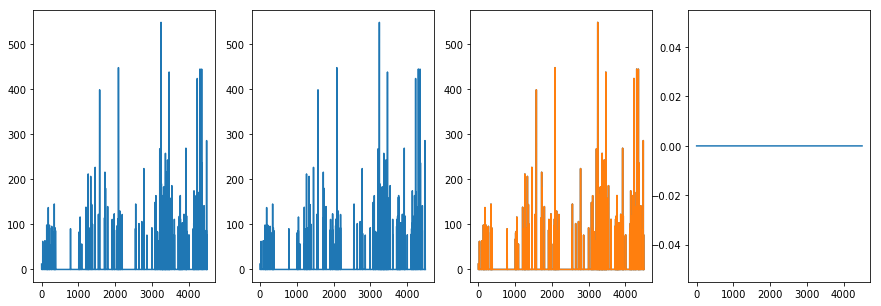

In [9]:
# Check
n = np.random.randint(len(ca_import))
ca_iter = ca_import.iteritems()
for _ in xrange(n):
    key, val = ca_iter.next()

c = np.random.randint(len(val))
print key, c

x1 = val[c]
x2 = neural_df[key + (c, )].as_matrix()
f = min(len(x1), len(x2))

fig, ax = plt.subplots(ncols=4, figsize=(15, 5))
ax[0].plot(x1);
ax[1].plot(x2);
ax[2].plot(x1);
ax[2].plot(x1);
ax[3].plot(x1[:f] - x2[:f]);
np.array_equal(x1[:f], x2[:f])


## Clean up imaging data

In [13]:
# Remove bad data

# Import files with cells to delete
delete_import = pd.concat(
    [pd.read_csv(del_pnt, delimiter=','), pd.read_csv(del_tmt, delimiter=',')],
    axis=1, keys=['PNT', 'TMT']
)
delete_import.columns = pd.MultiIndex.from_tuples(
    [[x[0], ] + x[1].split('_') for x in delete_import.columns],
    names=['experiment', 'subject']
)
delete_import = delete_import.unstack().dropna()
delete_import = delete_import.reset_index(level=-1, drop=True)
delete_import = delete_import.reorder_levels(['subject', 'experiment'])
delete_import -= 1

cells_to_delete = pd.concat(
    [delete_import.astype(int)] * 2,
    axis=1, keys=['index', 'to_delete']
).set_index('index', append=True).index.tolist()
to_delete = [(exp, ) + x for x in cells_to_delete for exp in set(['Spikes', 'Traces'])]

before = neural_df.shape[1]
neural_df = neural_df.reorder_levels(['datatype', 'subject', 'experiment', 'neuron', 'order'], axis=1)
neural_df = neural_df.drop(to_delete, axis=1, errors='ignore')
neural_df = neural_df.dropna(axis=0)
neural_df = neural_df.reorder_levels(['datatype', 'subject', 'experiment', 'order', 'neuron'], axis=1)
after = neural_df.shape[1]
print('{} neurons deleted. {} supposed to be deleted'.format(before - after, len(to_delete)))

## Register neurons

In [78]:
# Match cells
# Iterate over experiments, choosing only cells in peanut oil ones. Assign number based on match file.

match_import = pd.read_csv(match_file, delimiter=',', header=0)
match_import -= 1  # start indexing at 0

neural_df_new = []  # new dataframe with updated matched cell labelling
# for grp, grp_df in neural_df.loc[slice(None), (slice(None), 'H188')].groupby(level='subject', axis=1):
for grp, grp_df in neural_df.groupby(level='subject', axis=1):
    # Check if cell is in matches file
    if grp in match_import:
        key = match_import[grp]
    else:
        print('No matches for {}'.format(grp))
        
        # Check if there are peanut oil experiments
        pnt_cells = [x[-1] for x in grp_df.xs('PNT', axis=1, level='experiment')]
        if pnt_cells:
            # Make a map that matches all cells to nan
            key = np.nan * np.zeros(max([x[-1] for x in grp_df.xs('PNT', axis=1, level='experiment')]) + 1)
        else:
            print('No peanut oil experiments for {}'.format(grp))
            neural_df_new.append(grp_df)
            continue

    try:
#         n_tmt_cells = max([x[-1] for x in grp_df.xs('TMT', axis=1, level='experiment')]) + 1
        n_tmt_cells = int(key.max()) + 1  # Sometimes matches go higher than actual TMT cells on hand
        print grp, n_tmt_cells
    except ValueError:
        print('No TMT experiments found for {}'.format(grp))
        n_tmt_cells = 0

    grp_df = grp_df.stack(level='datatype')
    new_cols = grp_df.columns.tolist()
    for n, col in enumerate(new_cols):  # should groupby neuron here (to include spikes, traces)
        # Only look at the peanut oil cells (since that's the reference in match.csv)
        if 'PNT' in col:
            neuron_id = col[-1]
            matched_cell = key[neuron_id]
#             pdb.set_trace()
            if np.isfinite(matched_cell) and matched_cell < n_tmt_cells:
                new_cols[n] = col[:-1] + (int(matched_cell), )  # should rename all instances of neuron
            else:
                new_cols[n] = col[:-1] + (col[-1] + n_tmt_cells, )

    grp_df.columns = pd.MultiIndex.from_tuples(new_cols, names=grp_df.columns.names)
    grp_df = grp_df.unstack(level='datatype').reorder_levels(['datatype', 'subject', 'experiment', 'order', 'neuron'], axis=1)
    neural_df_new.append(grp_df)

neural_df_matched = pd.concat(neural_df_new, axis=1).sort_index(axis=1)

No matches for H123
No peanut oil experiments for H123
No matches for H169
No peanut oil experiments for H169
No matches for H170
No peanut oil experiments for H170
No matches for H185
No peanut oil experiments for H185
No matches for H186
No peanut oil experiments for H186
No matches for H187
No peanut oil experiments for H187
H188 90
J1 36
No matches for J52
No peanut oil experiments for J52
No matches for J53
No TMT experiments found for J53
No matches for J54
No TMT experiments found for J54
No matches for J55
No peanut oil experiments for J55


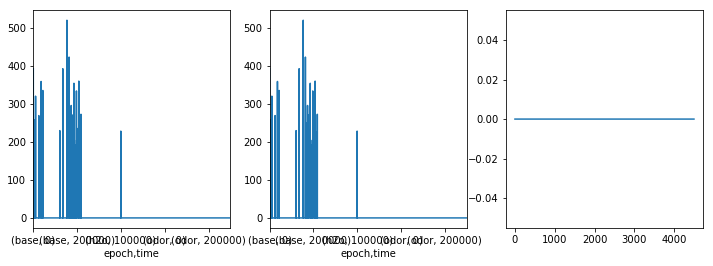

In [79]:
# Check registration
animal = 'H188'
cell_before = 44
cell_after = 46


x1 = neural_df.loc[slice(None), ('Spikes', animal, 'PNT', 'A', cell_before)]
x2 = neural_df_matched.loc[slice(None), ('Spikes', animal, 'PNT', 'A', cell_after)]

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
x1.plot(ax=axes[0])
x2.plot(ax=axes[1])
axes[2].plot(x1.as_matrix().flatten() - x2.as_matrix().flatten())

## Save data

In [80]:
with pd.HDFStore(h5_out) as hf:
    hf['behav'] = behav_df
    hf['neural'] = neural_df_matched

---
<a id='epm'></a>
# Elevated-plus maze

In [98]:
behav_source = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_EPM/PNOC_Behavior/*.xlsx'
trace_source = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_EPM/PNOC_Traces/*.txt'
event_source = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/PNOC_EPM/PNOC_Spikes/*.txt'

del_epm = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/del_epm.csv'

h5_outfile = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/miniscope/epm.h5'

## Import data

In [9]:
# Parameters

bin_size = 200
exp_dur = 600000
n_cores = 6

### Import behavioral data

In [20]:
# Import data

def import_behav(filename):
    _, subj, epoch = os.path.splitext(os.path.basename(filename))[0].split('_')
    data = custom.etho_extract(filename)
    data.index = data.index * 1000
    
    return (subj, epoch), data

behav_files = glob.glob(behav_source)
p = mp.Pool(processes=n_cores)
exps, behav_import = zip(*p.map(import_behav, behav_files))

In [21]:
# Correct for extra 10 s at beginning of behavioral data
for data in behav_import:
    data.index -= 10000

### Downsample data

In [30]:
# Create dataframe from all animals

ts = np.arange(0, exp_dur, bin_size)
subjs = [x for x, _ in exps]

dfs = {}  # Dictionary to store DataFrame from each animal
for subj, data in zip(subjs, behav_import):
    data_ds = custom.resample(data, data.index, ts, method=np.nanmean)
    ds_df = pd.DataFrame(data_ds, columns=data.columns, index=ts)
    ds_df.columns.names = ['feature']
    ds_df.index.names = ['timestamp']
    dfs[subj] = ds_df

# Create DataFrame for all data
behav_df = pd.concat(dfs, axis=1, names=['subject', 'feature'])
behav_df = behav_df.sort_index(axis=1, level=0)

/data/Dropbox (Stuber Lab)/analysis/random/custom/custom.py:37: RuntimeWarning: Mean of empty slice
  data_ds[..., bin_ds] = method(data[..., bin_pts], axis=-1)


### Import calcium imaging data
Each session is 1499 or 1500 frames

In [32]:
# Parameters

frame_dur = 200

In [33]:
# Gather files
trace_files = glob.glob(trace_source)
event_files = glob.glob(event_source)

# Import data
trace_import = {
    os.path.basename(f).split('_')[1]: pd.DataFrame(np.loadtxt(f, delimiter=',').T)
    for f in trace_files
}
event_import = {
    os.path.basename(f).split('_')[1]: pd.DataFrame(np.loadtxt(f, delimiter=',').T)
    for f in event_files
}

In [37]:
# Create DataFrame

trace_df = pd.concat(trace_import, axis=1)
event_df = pd.concat(event_import, axis=1)
neural_df = pd.concat([trace_df, event_df], axis=1, keys=['trace', 'event'], names=['datatype', 'subject', 'neuron'])
neural_df.index = np.arange(0, exp_dur, frame_dur)

### Downsample data (if necessary)

In [ ]:
ts = np.arange(0, exp_dur, bin_size)
data_ds = custom.resample(neural_df_orig, neural_df.index, ts, method=np.nanmean)

In [41]:
neural_df = pd.DataFrame(neural_df, columns=neural_df.columns, index=ts)
neural_df.index.name = 'timestamp'

### Clean data

In [96]:
# Remove bad data

# Import files with cells to delete
delete_import = pd.read_csv(del_epm, delimiter=',')
delete_import -= 1
delete_import = delete_import.unstack().dropna()
delete_import = delete_import.reset_index(level=-1, drop=True).astype(int)
delete_import = delete_import.reset_index()
delete_import.columns = ['subject', 'neuron']

# Delete cells
neural_df_cleaned = neural_df.drop([('trace', ) + tuple(x) for x in delete_import.as_matrix()] + [('event', ) + tuple(x) for x in delete_import.as_matrix()], axis=1)

### Save data

In [97]:
with pd.HDFStore(h5_outfile) as hf:
    hf['behav'] = behav_df
    hf['neural'] = neural_df_cleaned

/home/rung/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:486: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0_level1] [items->None]

  self.put(key, value)
/home/rung/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:486: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items_level1] [items->None]

  self.put(key, value)


---
<a id='headfixed'></a>
# Headfixed exposure
Create behavioral file with `pupilize`

In [5]:
frame_dur = 200
threshold = 225

# Input files
del_pnt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/del_hf-pnt-old.csv'
del_tmt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/del_hf-tmt-old.csv'
# hf_match_file = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/matches.csv'

raw_data_pnt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFPNT/PNOC_Behavior'
raw_data_tmt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFTMT/PNOC_Behavior'

# ca_files = glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFPNT/PNOC_Traces/*.txt') + \
#            glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFTMT/PNOC_Traces/*.txt') + \
#            glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFPNT/PNOC_Spikes/*.txt') + \
#            glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFTMT/PNOC_Spikes/*.txt')

ca_files = glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFPNT/PNOC_Traces/*.txt') + \
           glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFTMT/PNOC_Traces/*.txt') + \
           glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFPNT/PNOC_Spikes/*.txt') + \
           glob.glob('/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/2P Data/PNOC_HFTMT/PNOC_Spikes/*.txt')

# Output files
h5_out = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/headfixed_180328.h5'
h5_out_pnt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/hf-data-pnt.h5'
h5_out_tmt = '/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/hf-data-tmt.h5'

## Create behavioral data

In [6]:
%%bash -s "$h5_out_pnt" "$raw_data_pnt" "$frame_dur" "$threshold"

source activate py2
"/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py" -n 7 -t $4 -b $3 -o "$1" "$2"

INFO: activate-gfortran_linux-64.sh made the following environmental changes:
+DEBUG_FFLAGS=-fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-all -fno-plt -Og -g -Wall -Wextra -fcheck=all -fbacktrace -fimplicit-none -fvar-tracking-assignments -pipe
+DEBUG_FORTRANFLAGS=-fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-all -fno-plt -Og -g -Wall -Wextra -fcheck=all -fbacktrace -fimplicit-none -fvar-tracking-assignments -pipe
+F77=/home/rung/anaconda3/envs/py2/bin/x86_64-conda_cos6-linux-gnu-gfortran
+F95=/home/rung/anaconda3/envs/py2/bin/x86_64-conda_cos6-linux-gnu-f95
+FC=/home/rung/anaconda3/envs/py2/bin/x86_64-conda_cos6-linux-gnu-gfortran
+FFLAGS=-fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protect

/home/rung/anaconda3/envs/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(epoch_dict[epoch], col_name + ('pupil', ), pupil_resampled)
/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py:68: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(epoch_dict[epoch], col_name + ('trials', ), trials)
/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[]

In [7]:
%%bash -s "$h5_out_tmt" "$raw_data_tmt" "$frame_dur" "$threshold"

source activate py2
"/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py" -n 7 -t $4 -b $3 -o "$1" "$2"

INFO: activate-gfortran_linux-64.sh made the following environmental changes:
+DEBUG_FFLAGS=-fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-all -fno-plt -Og -g -Wall -Wextra -fcheck=all -fbacktrace -fimplicit-none -fvar-tracking-assignments -pipe
+DEBUG_FORTRANFLAGS=-fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-all -fno-plt -Og -g -Wall -Wextra -fcheck=all -fbacktrace -fimplicit-none -fvar-tracking-assignments -pipe
+F77=/home/rung/anaconda3/envs/py2/bin/x86_64-conda_cos6-linux-gnu-gfortran
+F95=/home/rung/anaconda3/envs/py2/bin/x86_64-conda_cos6-linux-gnu-f95
+FC=/home/rung/anaconda3/envs/py2/bin/x86_64-conda_cos6-linux-gnu-gfortran
+FFLAGS=-fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protect

/home/rung/anaconda3/envs/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(epoch_dict[epoch], col_name + ('pupil', ), pupil_resampled)
/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py:68: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(epoch_dict[epoch], col_name + ('trials', ), trials)
/data/Dropbox (Stuber Lab)/analysis/pnoc/organize_behav.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[]

In [8]:
# Combine datasets

# Read individual dataset files
with pd.HDFStore(h5_out_pnt, 'r') as hf_pnt, pd.HDFStore(h5_out_tmt, 'r') as hf_tmt:
    df_behav = pd.concat(
        [hf_pnt['behav'], hf_tmt['behav']],
        axis=1,
        keys=['PNT', 'TMT'],
        names=['experiment', ] + hf_pnt['behav'].columns.names
    )

# Rename index
df_behav = df_behav.rename(index={'ctrl': 'h2o', 'stim': 'odor'})

# Combine datasets
with pd.HDFStore(h5_out) as hf:
    hf['behav'] = df_behav

# Remove individual dataset files
os.remove(h5_out_pnt)
os.remove(h5_out_tmt)

In [9]:
h5_out_tmt

'/data/Dropbox (Stuber Lab)/We PNOC-ing/Latest PNOC Data/hf-data-tmt.h5'

## Import neural data

In [13]:
# Parameters

frames_per_epoch = 1505
frame_period = 200

Need to check frame counts on new files

In [14]:
# Number of frames for each epoch
frame_ct = {
    'J31_TMT_A_P1': [1505, 1505, 1505],
    'J50_TMT_A_P1': [1505, 1505, 1505],
    'J51_TMT_A_P1': [1504, 1504, 1504],
    'J51_TMT_A_P2': [1504, 1504, 1504],
    'J52_TMT_A_P1': [1505, 1505, 1505],
    'J52_TMT_A_P2': [1505, 1505, 1504],
    'J53_TMT_B_P1': [1505, 1505, 1505],
    'J53_TMT_B_P2': [1505, 1505, 1505],
    'J54_PNT_B_P1': [1505, 1505, 1505], #
    'J54_PNT_B_P2': [1505, 1505, 1505], #
    'J55_TMT_B_P1': [1505, 1505, 1505],
    'J31_PNT_B_P1': [1505, 1505, 1505],
    'J50_PNT_B_P1': [1505, 1505, 1505],
    'J51_PNT_B_P1': [1505, 1505, 1505],
    'J51_PNT_B_P2': [1505, 1505, 1505],
    'J52_PNT_B_P1': [1505, 1505, 1505],
    'J52_PNT_B_P2': [1505, 1505, 1505],
    'J53_PNT_A_P1': [1505, 1505, 1505],
    'J53_PNT_A_P2': [1505, 1505, 1504],
    'J54_PNT_A_P1': [1505, 1505, 1505], #
    'J54_PNT_A_P2': [1505, 1505, 1505], #
    'J55_PNT_A_P1': [1505, 1505, 1505],
}

In [15]:
# Import data

ca_import = {
    tuple(os.path.splitext(os.path.basename(f))[0].split('_')): np.loadtxt(f, delimiter=',')
    for f in ca_files
}

In [16]:
# Create dataframe for calcium traces

# Create new dictionary with key for each neuron
ca_data = {}
for exp, exp_data in ca_import.iteritems():
    n_cells, n_frames = exp_data.shape
    exp_id = frame_ct['_'.join(exp[1:])]
    
    epoch_split = np.split(exp_data, np.cumsum(exp_id)[:2], axis=1)
    epoch_split_new = [
        np.concatenate([epoch, np.nan * np.zeros((n_cells, frames_per_epoch - nf))], axis=1)
        for epoch, nf in zip(epoch_split, exp_id)
    ]
    traces_new = np.concatenate(epoch_split_new, axis=1)
    
    for n, cell_data in enumerate(traces_new):
        ca_data[exp + (n, )] = cell_data

# Create dataframe
neural_df = pd.DataFrame(ca_data)

# Format columns
col_names = ['data type', 'subject', 'experiment', 'order', 'plane', 'neuron']
col_order = ['data type', 'experiment', 'subject', 'plane', 'order', 'neuron']
neural_df.columns.names = col_names
neural_df = neural_df.reorder_levels(col_order, axis=1)
neural_df = neural_df.sort_index(axis=1)

# Format index
neural_df.index = pd.MultiIndex.from_product(
    [['base', 'h2o', 'odor'], np.arange(frames_per_epoch) * frame_period],
    names=['epoch', 'time']
)

In [18]:
# Remove bad data

delete_import = pd.concat(
    [pd.read_csv(del_pnt, delimiter=','), pd.read_csv(del_tmt, delimiter=',')],
    axis=1, keys=['PNT', 'TMT']
)
delete_import.columns = pd.MultiIndex.from_tuples(
    [[x[0], ] + x[1].split('_') for x in delete_import.columns]
)

# Cells to delete from TMT dataset
to_delete = [
    col + (int(x) - 1, )
    for col in delete_import for x in delete_import[col]
    if not np.isnan(x)
]

temp = neural_df.T.reset_index(['data type', 'order']).T
temp = temp.drop(to_delete, axis=1)
temp = temp.T.set_index(['data type', 'order'], append=True).T
temp = temp.reorder_levels(col_order, axis=1)
temp = temp.sort_index(axis=1)
neural_df = temp.dropna(axis=0).astype(float)

Need to make sure this works with spiking data also

In [19]:
# Match cells
# Iterate over experiments, choosing only cells in peanut oil ones. Assign number based on match file.

match_import = pd.read_csv(hf_match_file, delimiter=',', header=0)
match_import -= 1  # start indexing at 0
match_import.columns = pd.MultiIndex.from_tuples(
    [[x.split('_')[0], x.split('_')[1]] for x in match_import.columns],
    names=['subject', 'plane']
)

neural_df_new = []  # new dataframe with updated matched cell labelling
for grp, grp_df in neural_df.groupby(level=['subject', 'plane'], axis=1):
    try:
        n_tmt_cells = max([x[-1] for x in grp_df.xs('TMT', axis=1, level='experiment')]) + 1
        print grp, n_tmt_cells
    except ValueError:
        print('No TMT experiments found for {}'.format(grp))
        continue
    key = match_import[grp]

    col = grp_df.columns.tolist()
    for n, x in enumerate(col):
        if 'PNT' in x:
            neuron_id = x[-1]
            matched_cell = key[neuron_id]
            if not np.isnan(matched_cell):
                col[n] = x[:-1] + (int(matched_cell), )
            else:
                col[n] = x[:-1] + (x[-1] + n_tmt_cells, )

    grp_df.columns = pd.MultiIndex.from_tuples(col, names=grp_df.columns.names)
    neural_df_new.append(grp_df)

neural_df_matched = pd.concat(neural_df_new, axis=1).sort_index(axis=1)

# # Following doesn't work...
# def match_cells(paired_df):
#     ''' Rename cells based on match from CSV file
#     Doesn't work because `groupby` won't change column names on original dataframe... -_-
#     '''
#     n_tmt_cells = max([x[-1] for x in paired_df.xs('TMT', axis=1, level='odor')]) + 1
#     key = match_import[paired_df.columns[0][2:4]]

#     col = paired_df.columns.tolist()
#     for n, x in enumerate(col):
#         if 'PNT' in x:
#             neuron_id = x[-1]
#             if not np.isnan(key[neuron_id]):
#                 col[n] = x[:-1] + (int(key[neuron_id]), )
#             else:
#                 col[n] = x[:-1] + (x[-1] + n_tmt_cells, )

#     paired_df.columns = pd.MultiIndex.from_tuples(col, names=paired_df.columns.names)
#     return paired_df

# neural_df = neural_df.groupby(level=['subject', 'plane'], axis=1).apply(match_cells)

NameError: name 'hf_match_file' is not defined

### Save data

In [20]:
with pd.HDFStore(h5_out) as hf:
#     hf['neural'] = neural_df_matched
    hf['neural'] = neural_df

/home/rung/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/io/pytables.py:486: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1_level1] [items->None]

  self.put(key, value)
